# Обучение эмбеддингов (Metric Learning)
Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

## Загрузка библиотек

In [ ]:
#%tensorflow_version 2.x

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

import pandas as pd 
import seaborn as sns

## Загрузка и подготовка датасета LFW

In [2]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw', 
    as_supervised=True,
    with_info=True,
    split=['train[:75%]', 'train[25%:]'],
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/13233 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/lfw/0.1.0.incompletePKZ75A/lfw-train.tfrecord*...:   0%|          | 0/13233 [0…

Dataset lfw downloaded and prepared to ~/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


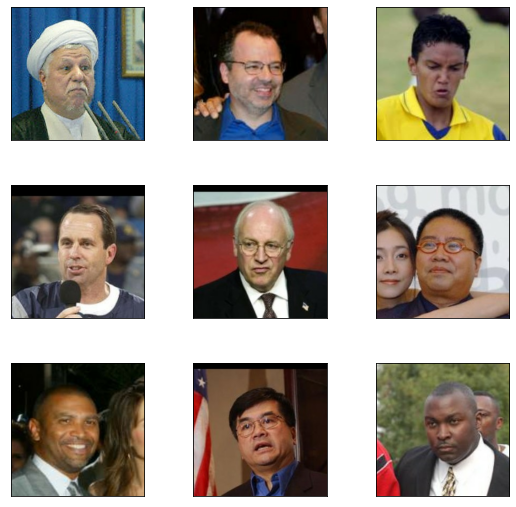

In [3]:
fig = tfds.show_examples(test_ds, ds_info)

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='lfw',
    full_name='lfw/0.1.0',
    description="""
    Labeled Faces in the Wild:
            A Database for Studying Face Recognition in
            Unconstrained Environments
    """,
    homepage='http://vis-www.cs.umass.edu/lfw',
    data_path='~/tensorflow_datasets/lfw/0.1.0',
    file_format=tfrecord,
    download_size=172.20 MiB,
    dataset_size=180.28 MiB,
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    supervised_keys=('label', 'image'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=13233, num_shards=2>,
    },
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Am

## Создание модели CNN

In [4]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [5]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [6]:
NUM_EPOCHS = 5
BATCH_SIZE = 64

def prepare(label, image):
    image = tf.cast(image, tf.float32)/255.
    return image, label

train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.map(prepare)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

In [7]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(64, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.string, name=None))>

In [8]:
len(train_ds), len(test_ds)

(775, 77)

## Подготовка к обучению

In [9]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [33]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 100 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 90.34765625
[100] Loss: 0.0
[200] Loss: 0.0
[300] Loss: 0.005764685105532408
[400] Loss: 0.0
[500] Loss: 5.599152565002441
[600] Loss: 1.970073938369751
[700] Loss: 0.0
CPU times: user 2min 41s, sys: 7.73 s, total: 2min 48s
Wall time: 3min 17s


## Проверка на тестовой выборке

In [ ]:
prediction = model.predict(test_ds)

In [34]:
%%time

for iteration, (images, labels) in enumerate(test_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 10 == 0:
        print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))

[0] Loss: 0.07978948950767517
[10] Loss: 0.0
[20] Loss: 0.0
[30] Loss: 0.0
[40] Loss: 0.0
[50] Loss: 63.625022888183594
[60] Loss: 6.700747489929199
[70] Loss: 0.0
CPU times: user 16.1 s, sys: 1.2 s, total: 17.3 s
Wall time: 36.9 s


## Преобразование test_ds в объекты numpy (итерируемые)

In [11]:
for images, labels in test_ds.take(-1):  # -1 means we take all elements of dataset
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()

In [14]:
print(numpy_images.shape)

(128, 250, 250, 3)


## We got a four-dimensional data, we'll reshape it into the two-dimensional one. 

In [16]:
from numpy import reshape
test_x_flat = reshape(numpy_images, [numpy_images.shape[0], numpy_images.shape[1]*numpy_images.shape[2]*numpy_images.shape[3]])
print(test_x_flat.shape)

(128, 187500)


## Here, we have 187500 features data.  
## Визуализация образцов LFW в 2D пространстве с помощью TSNE

In [21]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(test_x_flat)
df = pd.DataFrame()
df["y"] = numpy_labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 128 samples in 0.029s...
[t-SNE] Computed neighbors for 128 samples in 1.254s...
[t-SNE] Computed conditional probabilities for sample 128 / 128
[t-SNE] Mean sigma: 48.833675
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.091385
[t-SNE] KL divergence after 1000 iterations: 0.520805


In [51]:
len(np.unique(numpy_labels))

117

[Text(0.5, 1.0, 'LFW data T-SNE projection')]

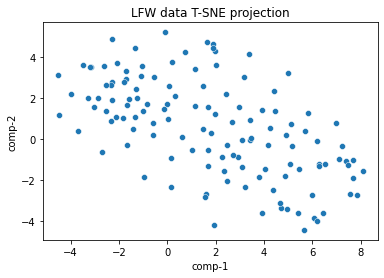

In [32]:
sns.scatterplot(x="comp-1", y="comp-2", #hue=df.y.tolist(),
                #palette=sns.color_palette("hls", 117),
                data=df).set(title="LFW data T-SNE projection")

## Получение эмбеддингов для тестовой выборки

In [36]:
test_embs = model(numpy_images)

## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [37]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(test_embs)
df = pd.DataFrame()
df["y"] = numpy_labels
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 128 samples in 0.001s...
[t-SNE] Computed neighbors for 128 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 128 / 128
[t-SNE] Mean sigma: 6.307391
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.740585
[t-SNE] KL divergence after 950 iterations: 0.482143


[Text(0.5, 1.0, 'LFW data T-SNE projection')]

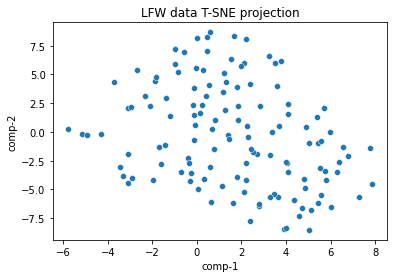

In [38]:
sns.scatterplot(x="comp-1", y="comp-2", #hue=df.y.tolist(),
                #palette=sns.color_palette("hls", 117),
                data=df).set(title="LFW data T-SNE projection")

## Тестирование на новых данных

In [57]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250), order=3, mode='reflect', anti_aliasing=True)
    img = (1. - img).astype(np.float32)
    #img = np.mean(img, axis=2)
    img = np.reshape(img, (250, 250, 3))
    return img

img_a1 = load_and_prepare_image('foto_1.jpeg')
img_a2 = load_and_prepare_image('foto_2.jpeg')
img_b1 = load_and_prepare_image('foto_3.jpeg')

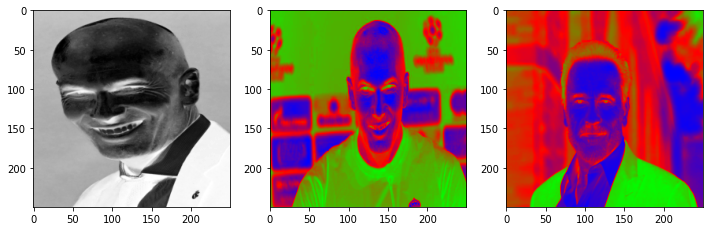

In [55]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_a1[:,:,0], cmap='gray')
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_a2[:,:,0], cmap='brg')
ax = fig.add_subplot(1, 3, 3)
ax.imshow(img_b1[:,:,0], cmap='brg')
plt.show()

## Получение эмбеддингов для новых данных

In [58]:
new_embs = model(np.stack((img_a1, img_a2, img_b1), axis=0))

## Вычисление расстояний между эмбеддингами

---

In [59]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A2 <-> B1: ', diff(emb2, emb3))
print('A1 <-> B1: ', diff(emb1, emb3))

A1 <-> A2:  9.627065461722845
A2 <-> B1:  12.791936384871892
A1 <-> B1:  13.930043505335757
